## Example 11 - Simulation Exercise

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Create sites

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
Quay = type('Quay', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.HasLength), {})
Turn = type('Turn', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.RequiresTurning), {})


data_node_01 = {"env": [],
               "name": "anchorage",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_02 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(2, 0)}
data_node_03 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(4, 0)}
data_node_04 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(5, 0)}

data_node_05 = {"env": [],
               "name": "tb5",
               "geometry": shapely.geometry.Point(9, 0)}
data_node_07 = {"env": [],
               "name": "tb7",
               "geometry": shapely.geometry.Point(12, 0)}
data_node_09 = {"env": [],
               "name": "tb9",
               "geometry": shapely.geometry.Point(15, 0)}


data_berth_52 = {"env": [],
               "name": "b52",
               "geometry": shapely.geometry.Point(9, -1),
               "length": 300}
data_berth_62 = {"env": [],
               "name": "b62",
               "geometry": shapely.geometry.Point(12, -1),
               "length": 300}
data_berth_72 = {"env": [],
               "name": "b72",
               "geometry": shapely.geometry.Point(15, 1),
               "length": 300}

anchor = Node(**data_node_01)
node_1 = Node(**data_node_02)
node_2 = Node(**data_node_03)
node_3 = Node(**data_node_04)
tb1    = Node(**data_node_05)
tb2    = Node(**data_node_07)
tb3    = Node(**data_node_09)

berth1 = Quay(**data_berth_52)
berth2 = Quay(**data_berth_62)
berth3 = Quay(**data_berth_72)

nodes1 = [anchor, node_1, node_2, node_3, tb1, berth1, tb2, berth2, tb3, berth3]

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

at quay
at quay
at quay
('tb9', 'b72')


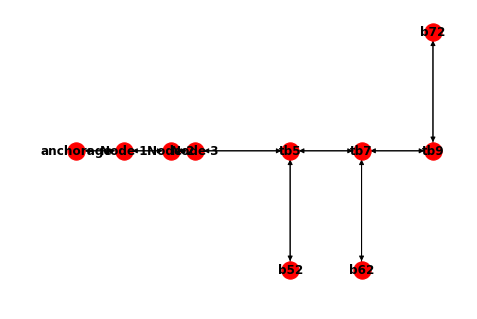

In [3]:
FG = nx.DiGraph()

positions = {}
it=-1
for node in nodes1:
    it+=1
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)
    if isinstance(node, Quay):
        itnum=it
        print("at quay")
        obj = 'quay'
        
path = [[anchor, node_1], # From node 1 to node 2
        [node_1, node_2], # From node 2 to node 3
        [node_2, node_3], # From node 3 to node 4
        [node_3, tb1], # From node 3 to node 2
        [tb1, berth1],
        [berth1, tb1],
        [tb1, tb2],
        [tb2, berth2],
        [berth2, tb2],
        [tb2, tb3],
        [tb3, berth3],
        [berth3, tb3],
        [tb3, tb2],
        [tb2, tb1],
        [tb1, node_3], # From node 3 to node 4
        [node_3, node_2],
        [node_2, node_1],
        [node_1, anchor]] # From node 4 to node 3 - So one-way traffic is from node 1 to node 4

it=-2
for edge in path:
    it+=1
    if it==itnum:
        print((edge[0].name, edge[1].name))
        FG.add_edge(edge[0].name, edge[1].name, Object = "quay", weight = 1)
    else:
        FG.add_edge(edge[0].name, edge[1].name, weight = 1)

nx.draw(FG, positions, with_labels=True, font_weight='bold')
plt.show()

In [4]:
# To show that moving from Node 4 to Node 1 is not possible
print("From b52 to b62:", nx.shortest_path_length(FG, "b52", "b72"), "steps.")
print("From b62 to anchorage:", nx.shortest_path_length(FG, "b72", "anchorage"), "steps.")
# print("From 4 to 1:", nx.shortest_path_length(FG, "Node 4", "Node 1"))

From b52 to b62: 4 steps.
From b62 to anchorage: 7 steps.


### Create vessels

#### define paths

In [5]:
# Vessel1 moves first from "anchorage" to "b72" and then back to "anchorage"
path_1 = nx.dijkstra_path(FG, "anchorage", "b72")
path_2 = nx.dijkstra_path(FG, "b72", "anchorage")
path_vessel_1 = np.concatenate((path_1, path_2[1:]), axis = None)

# Vessel1 moves first from "anchorage" to "b52" and then back to "anchorage"
path_1 = nx.dijkstra_path(FG, "anchorage", "b52")
path_2 = nx.dijkstra_path(FG, "b52", "anchorage")
path_vessel_2 = np.concatenate((path_1, path_2[1:]), axis = None)

#### define vessels

In [6]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable, core.Berthable), {})

# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel_1 = {"env": None,
               "name": "Vessel number 1",
               "route": path_vessel_1,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "lengthquay": berth3.length,
               "lengthvessel": 100,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}
data_vessel_2 = {"env": None,
               "name": "Vessel number 2",
               "route": path_vessel_2,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "lengthquay": berth3.length,
               "lengthvessel": 80,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

vessels = []
# create the transport processing resource
vessels.append(TransportResource(**data_vessel_1))
vessels.append(TransportResource(**data_vessel_2))

# dit werkt beter dan vessels kopieren en dan properties aanpassen. 
# Python beschouwt kopieen vaak als gekoppelde objecten.

### Run simulation

In [7]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        print("{} started sailing".format(vessel.name))
 
        yield from vessel.move()
    
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        print("{} stopped sailing".format(vessel.name))
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [8]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
for vessel in vessels:
    vessel.env = env
    vessel.service_time = 18000

    # Start the simulation
    print("instantiate {}".format(vessel.name))
    env.process(start(env, vessel))

# instantiate all processes and only execute env.run() once at the end
env.run()

# print("Simulation of path {} took {} seconds".format(path, int(env.now)))

instantiate Vessel number 1
instantiate Vessel number 2
Vessel number 1 started sailing
Vessel number 2 started sailing
Vessel number 1 at quay, service time is 18000 sec
Remaining available quay length is 200.0 m.
Vessel number 2 stopped sailing
Vessel number 1 stopped sailing


### Testing